## Grab long, HQ files from local SQLite DB

In [ ]:
!pip install sqlite3, quickumls
# I needed ~16GB RAM for this step, contributed to GitHub issue fix
!python -m quickumls.install "/mnt/isilon/wang_lab/shared/datasets/UMLS_unzipped/2019AB-full/UMLS_lib/2019AB/META/" quickumlsdata
!python -m pip install git+https://github.com/GeneDx/phenopy.git@develop
!python -m pip install git+https://github.com/GeneDx/txt2hpo.git@develop

In [3]:
!pip install cx_Oracle

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 814 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/cm/shared/apps_chop/python/3.9.1/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
import os, argparse, sys
import cx_Oracle                                                                       
import time
import sys
import sqlite3
import os
import numpy as np
import scipy.stats as ss

## Fill in your username and password
clarity_user = ''
clarity_psw = ''

## if 'exaorat2' does not work, try 'exaorav2'
dsnStr = cx_Oracle.makedsn("exaorat2-scan.chop.edu", "1521", service_name="CLTprd_pri.chop.edu")
remote_con = cx_Oracle.connect(user = clarity_user, password = clarity_psw, dsn = dsnStr)
remote_cur = remote_con.cursor()

## Get demographic data

In [4]:
xstr = lambda s: 'Unknown' if s is None else str(s)

In [17]:
remote_cmd = """
select * from ZC_ETHNIC_GROUP where rownum <10
"""

### execute the sql command
remote_cur.execute(remote_cmd)

### fetch all the data 
ethnicities = remote_cur.fetchall()

### num of queried patients (as on 12/14/2020)
print(ethnicities)

remote_cmd = """
select * from ZC_SEX where rownum <10
"""

### execute the sql command
remote_cur.execute(remote_cmd)

### fetch all the data 
genders = remote_cur.fetchall()

### num of queried patients (as on 12/14/2020)
print(genders)

[(1, 'White', 'WHITE', 'WH', 1), (2, 'Black or African American', 'BLACK OR AFRICAN AMERICAN', 'BL', 2), (4, 'American Indian/Eskimo/Alaska Native', 'AMERICAN INDIAN/ESKIMO/ALASKA NATIVE', 'AI', 4), (5, 'Asian', 'ASIAN', 'AP', 5), (6, 'Other', 'OTHER', 'OT', 6), (7, 'Hispanic or Latino White', 'HISPANIC OR LATINO WHITE', 'HIWH', 7), (8, 'Hispanic or Latino Black', 'HISPANIC OR LATINO BLACK', 'HIBL', 8), (9, 'Hispanic or Latino Other', 'HISPANIC OR LATINO OTHER', 'HIOT', 9), (10, 'Native Hawaiian/Pacific Islander', 'NATIVE HAWAIIAN/PACIFIC ISLANDER', 'NHPI', 10)]
[('1', 'Female', 'FEMALE', 'F', '1'), ('2', 'Male', 'MALE', 'M', '2'), ('3', 'Unknown', 'UNKNOWN', 'U', '3'), ('950', 'Nonbinary', 'NONBINARY', 'NB', '950'), ('951', 'X', 'X', 'X', '951'), ('999', 'Other', 'OTHER', 'OTH', '999')]


In [19]:
remote_cmd = """
select * from ZC_PATIENT_RACE where rownum <=10
"""

### execute the sql command
remote_cur.execute(remote_cmd)

### fetch all the data 
races = remote_cur.fetchall()

### num of queried patients (as on 12/14/2020)
print(races)


[(1, 'White', 'WHITE', 'WH', 1), (2, 'Black or African American', 'BLACK OR AFRICAN AMERICAN', 'BL', 2), (3, 'DO NOT USE', 'DO NOT USE', 'DO NOT USE', 3), (4, 'American Indian or Alaska Native', 'AMERICAN INDIAN OR ALASKA NATIVE', 'AI', 4), (5, 'Asian', 'ASIAN', 'AP', 5), (6, 'Other', 'OTHER', 'OT', 6), (7, 'Hispanic or Latino White', 'HISPANIC OR LATINO WHITE', 'HIWH', 7), (8, 'Hispanic or Latino Black', 'HISPANIC OR LATINO BLACK', 'HIBL', 8), (9, 'Hispanic or Latino Other', 'HISPANIC OR LATINO OTHER', 'HIOT', 9), (10, 'Native Hawaiian or Other Pacific Islander', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'NHPI', 10)]


In [49]:
remote_cmd = """

with ds as   (select dx.pat_id, dx.dx_id, dx.CONTACT_DATE as ddate
                from pat_enc_dx dx
                inner join pat_enc e on e.pat_enc_Csn_id = dx.pat_enc_Csn_id
                inner join edg_current_icd9 icd on icd.dx_Id = dx.dx_id
                where icd.code like '758.0%'

                union
                select dx.pat_id, dx.dx_id, dx.CONTACT_DATE as ddate
                from pat_enc_dx dx
                inner join pat_enc e on e.pat_enc_Csn_id = dx.pat_enc_Csn_id
                inner join edg_current_icd10 icd on icd.dx_Id = dx.dx_id
                where icd.code like 'Q90.9%'

                union
                select h.pat_id, hdx.dx_id, hdx.DX_START_DT as ddate
                from hsp_acct_dx_List hdx
                inner join pat_enc_hsp h on h.hsp_account_id = hdx.hsp_account_id
                inner join clarity_edg edg on edg.dx_Id = hdx.dx_Id
                where (edg.ref_bill_code like '758.0%' or edg.ref_bill_code like 'Q90.9%')
                and edg.ref_bill_code_set_c in (1,2)
                -- ref_bill_code_set_c: 1 is ICD-9-CM and 2 is ICD-10-CM

                union
                select pl.pat_id, pl.dx_id, pl.NOTED_DATE as ddate
                from problem_list pl
                inner join edg_current_icd9 icd on icd.dx_Id = pl.dx_id
                where icd.code like '758.0%'
                and  (pl.problem_status_c is null or pl.problem_status_c <> 3)
                -- problem_status_c: 3 is deleted

                union
                select pl.pat_id, pl.dx_id, pl.NOTED_DATE as ddate
                from problem_list pl
                inner join edg_current_icd10 icd on icd.dx_Id = pl.dx_id
                where icd.code like 'Q90.9%'
                 and  (pl.problem_status_c is null or pl.problem_status_c <> 3)

                 ) -- inclusion diagnoses
                 
select distinct(p.pat_id), p.sex_c, p.ethnic_group_c, PATIENT_RACE.patient_race_c,
        (ddate-p.birth_date)/365.25 as page
        from patient p
        inner join ds on ds.pat_id = p.pat_id
        inner join PATIENT_RACE on PATIENT_RACE.pat_id = p.pat_id
"""

### execute the sql command
remote_cur.execute(remote_cmd)

### fetch all the data 
data = remote_cur.fetchall()
print (len(data))

85402


In [50]:
# translation funcs/dicts here using ZC_SEX and ZC_ETHNIC_GROUP
genderdict = {item[0]: item[1:] for item in genders}
ethnicdict = {item[0]: item[1:] for item in ethnicities}
racedict = {item[0]: item[1:] for item in races}
patients=[]
with open('filters/truedspats') as f:
    for line in f:
        patients.append(line.strip())
from collections import defaultdict
demo=defaultdict(list)
for entry in data:
    patid=entry[0]; race=xstr(entry[3]); date=entry[4]
    if patid not in patients:
        continue
    try:
        sex=xstr(genderdict[entry[1]][0])
    except KeyError:
        sex="Unknown"
    try:
        ethnicity=xstr(ethnicdict[entry[2]][0])
    except KeyError:
        ethnicity="Unknown"
    try:
        race=xstr(racedict[entry[3]][0])
    except KeyError:
        race="Unknown"
    if not date or date > 21 or date < -0.8:
        date = 22
    if not demo[patid] or demo[patid][3]>date:
        demo[patid]=[sex,ethnicity,race,date]

4081


-0.30116977076873586
20.972367673531966
1.9863515335701623
4.913983336984749
ModeResult(mode=array([0.]), count=array([129]))


(array([1928.,  371.,  284.,  276.,  234.,  244.,  229.,  168.,  107.,
          77.]),
 array([-0.30116977,  1.82618397,  3.95353772,  6.08089146,  8.20824521,
        10.33559895, 12.4629527 , 14.59030644, 16.71766018, 18.84501393,
        20.97236767]),
 <BarContainer object of 10 artists>)

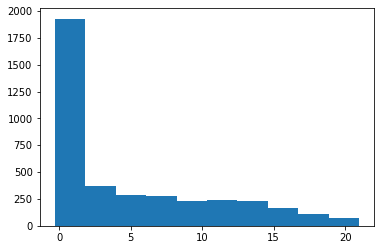

In [128]:
patages=defaultdict(lambda: 99.0)
ages=[]
with open("/mnt/isilon/wang_lab/jim/Down-Syndrome-Clustering/dsages.tsv") as f:
    f.readline()
    for line in f:
        fields=line.strip().split()
        pat=fields[0]; note=fields[1]; age=float(fields[2])
        patages[pat]=min(patages[pat],age)

for key, value in patages.items():
    temp = [key,value]
    ages.append(value)
ages=np.array(ages)
ages=ages[ages<21]
ages=ages[ages>-0.8]
print(min(ages))
print(max(ages))
print(np.nanmedian(ages))
print(np.nanmean(ages))
print(ss.mode(ages))
from matplotlib import pyplot as plt
plt.hist(ages)

In [34]:
with open("/mnt/isilon/wang_lab/jim/Down-Syndrome-Clustering/demographics.tsv", "w") as file:
    print("patient\tsex\tethnicity\tearliest_diagnosis_date", file=file)
    for patid in demo:
        sex,ethnicity,race,date = demo[patid]
        if date == 22:
            date="Unknown"
        date = str(date)
        print("\t".join([patid, sex, ethnicity, race, date]),file=file)

In [103]:
%%bash
cut -f 3,4 /mnt/isilon/wang_lab/jim/Down-Syndrome-Clustering/demographics.tsv | awk '{FS="\t"} {print $2"\t"$1}' | sort | uniq -c | grep Asian | awk '{t+=$1} END {print t}'

130


## Get age data for notes/terms

In [10]:
remote_cmd = """
select hno_info.pat_id,  
       htext.note_id, htext.CONTACT_DATE, pat.birth_date, hno_info.current_author_id
               
        from hno_info
        inner join hno_note_text htext on htext.note_id = hno_info.note_id
        inner join patient pat on pat.pat_id = hno_info.pat_id where rownum <=10
        and hno_info.current_author_id is not NULL
"""

### execute the sql command
remote_cur.execute(remote_cmd)

### fetch all the data 
data = remote_cur.fetchall()

### num of queried patients (as on 12/14/2020)
len(data)

10

In [2]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day
print(to_integer(data[1][2]))
print(data[1])

NameError: name 'data' is not defined

In [15]:
with open("/mnt/isilon/wang_lab/jim/patientnotes.tsv", "w") as file:
    print("patient\tnote\tadmission_date\tbirth_date", file=file)
    for entry in data:
        try:
            adate=str(to_integer(entry[2]))
        except AttributeError:
            adate="NA"
        try:
            bdate=str(to_integer(entry[3]))
        except AttributeError:
            bdate="NA"
        print("\t".join([entry[0],entry[1],adate,bdate]),file=file)


In [2]:
import sqlite3
## local sql-db name to store the notes of ASD patients
local_db_name = 'ds_patient_check.db'
## sqlite3.connect create a new sql-db if not exists, and it need ' .commit()' at the end to safe the sql-db
local_con = sqlite3.connect(local_db_name)
## .cursor() is to execute a sql_cmd, and to fetch data.
local_cur = local_con.cursor()
query="""
select * from note_text where length(note_text)>2000 and note_text like '%MRN:%' 
""" # add limit 20 to very end of query to limit and test lines
local_cur.execute(query)
data = local_cur.fetchall()
local_cur.close()


In [3]:
len(data) # 369,598 was Mengge's initial count of DS notes at >2000 chars

124104